In [243]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [244]:
df = pd.read_csv('cleaned_data.csv')
df.head()

,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,8222157,Caucasian,Female,[0-10),6,25,1,1,pediatrics,41,...,No,No,No,No,No,No,No,No,No,NO
1,55629189,Caucasian,Female,[10-20),1,1,7,3,missing,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,missing,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,82442376,Caucasian,Male,[30-40),1,1,7,2,missing,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,42519267,Caucasian,Male,[40-50),1,1,7,1,missing,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [245]:
df.drop(['patient_nbr'], axis=1, inplace=True)

In [246]:
df.race.unique()

array(['Caucasian', 'AfricanAmerican', 'Other'], dtype=object)

In [247]:
# convert cat race to num
replace_dict = {'Caucasian': 0, 'AfricanAmerican': 1, 'Other': 2}

df['race'] = df['race'].apply(lambda x: replace_dict[x])

In [248]:
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,0,Female,[0-10),6,25,1,1,pediatrics,41,0,...,No,No,No,No,No,No,No,No,No,NO
1,0,Female,[10-20),1,1,7,3,missing,59,0,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,1,Female,[20-30),1,1,7,2,missing,11,5,...,No,No,No,No,No,No,No,No,Yes,NO
3,0,Male,[30-40),1,1,7,2,missing,44,1,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,0,Male,[40-50),1,1,7,1,missing,51,0,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [249]:
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)

In [250]:
# convert cat age to num
replace_dict = {'[0-10)': 5,
                '[10-20)': 15,
                '[20-30)': 25,
                '[30-40)': 35,
                '[40-50)': 45,
                '[50-60)': 55,
                '[60-70)': 65,
                '[70-80)': 75,
                '[80-90)': 85,
                '[90-100)': 95}

df['age'] = df['age'].apply(lambda x: replace_dict[x])

In [251]:
# response variable 'readmitted', <30 -> 0, >30 1
df['readmitted'] = df['readmitted'].replace({'<30': 1, '>30': 0, 'NO': 0})

Discharge Disposiiton ID <br>
<p>
Discharge Disposition ID corresponding to [11 or 13 or 14 or 19 or 20 or 21] indicates patient has expired so there is no chance that it will readmit again so we will remove these records.
<p>

<p>
Discharge Disposition ID has lots of distinct values using domain knowledge we will convert them into small number of categories. <br>

ddi_cat1 = [1, 6, 7, 8] <br>
ddi_cat2 = [2, 3, 4, 5, 10, 15, 16, 17, 22, 23, 24, 27, 28, 29, 30] <br>
ddi_cat10 = [9, 12] <br>
ddi_cat11 = [11, 19, 20, 21] <br>
ddi_cat18 = [13, 14] <br>
</p>

In [252]:
 df['discharge_disposition_id'] = df['discharge_disposition_id'].apply(lambda x : 1 if int(x) in [6, 7, 8]
                                                                           else ( 2 if int(x) in [3, 4, 5, 10, 15, 16, 17, 22, 23, 24, 27, 28, 29, 30]
                                                                           else ( 9 if int(x) in [12]
                                                                           else ( 11 if int(x) in [19, 20, 21]
                                                                           else ( 18 if int(x) in [25, 26]
                                                                           else ( 13 if int(x) in [14] 
                                                                           else int(x) ))))))

df = df[~df.discharge_disposition_id.isin([11,19,20,21])]

Admission Type ID :
<p>
Similarly Admission Type ID can be converted into small number of categories <br>
ati_cat1 = [2, 7] <br>
ati_cat5 = [6, 8]
</p>

In [253]:
# 1 - emergency, 2 - urgent, 7 - trama center
# 3 - elective, 4 -new_born
# 5 - not applicable, 6 - null, 8 - not mapped
df['admission_type_id'] = df['admission_type_id'].apply(lambda x : 1 if int(x) in [2, 7]
                                                            else ( 5 if int(x) in [6, 8]
                                                            else int(x) ))

Admission Source ID :
<p>
Similarly Admission Source ID can be converted into small number of categories <br>
asi_cat1 = [2, 3] <br>
ati_cat4 = [5, 6, 10, 22, 25] <br>
ati_cat9 = [15, 17, 20, 21] <br>
ati_cat11 = [13, 17]
</p>

In [254]:
df['admission_source_id'] = df['admission_source_id'].apply(lambda x : 1 if int(x) in [2, 3]
                                                            else ( 4 if int(x) in [5, 6, 10, 22, 25, 26, 18]
                                                            else ( 9 if int(x) in [15, 17, 20, 21]
                                                            else ( 11 if int(x) in [12, 13, 14]
                                                            else ( 7 if int(x) in [8, 19, 23, 24]
                                                            else int(x) )))))

In [255]:
for col in ["metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone", "tolazamide", "insulin", "glyburide-metformin", "glipizide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone"]:
    df[col] = df[col].apply(lambda x : 10 if x == 'Up' 
                                              else ( -10 if x == 'Down'                                                          
                                              else ( 0 if x == 'Steady'
                                              else  -20)))


df['change'] = df['change'].apply(lambda x : 1 if x == 'Ch'
                                                 else -1)


df['diabetesMed'] = df['diabetesMed'].apply(lambda x : -1 if x == 'No'
                                                else 1)



<p>The diag_1 , diag_2 , diag_3 are categorical features but they have 
 lots unique values if we apply one hot encoding directely it will results in
 lots of feature values that will eventually invoke "curse of dimensionality" problem
 We will use the domain knowledge provided in the description of data to create fewer values.</p>

Domain Knowledge <br>
Type    -->         ICD Values -->      Description 

Circulatory    -->    390–459, 785   -->  Diseases of the circulatory system <br>
Respiratory   -->     460–519, 786   -->  Diseases of the respiratory system <br>
Digestive     -->     520–579, 787    --> Diseases of the digestive system <br>
Diabetes   -->        250.xx    -->       Diabetes mellitus <br>
Injury    -->          800–999    -->      Injury and poisoning <br>
Musculoskeletal -->    710–739 -->         Diseases of the musculoskeletal system and connective tissue <br>
Genitourinary     --> 580–629, 788   -->  Diseases of the genitourinary system <br>
Neoplasms       -->   140–239  -->        Neoplasms <br>
Pregnecy       -->    630–679  -->        Complications of pregnancy, childbirth, and the puerperium <br>
Other <br>

<p>We added Pregnecy as one category original description file kept it in 'Other' category but from research we found that 
Pregnecy creates unique type of diabetes and hence it  make sense to keep it as seperate category. </p>

In [256]:
print(len(np.unique(df['diag_1'])))  
print(len(np.unique(df['diag_2'])))  
print(len(np.unique(df['diag_3'])))  

df['diag_1'] = df['diag_1'].apply(lambda x : 'other' if (str(x).find('V') != -1 or str(x).find('E') != -1)  
                                        else ('circulatory' if int(float(x)) in range(390, 460) or int(float(x)) == 785
                                        else     ('respiratory' if int(float(x)) in range(460, 520) or int(float(x)) == 786
                                        else     ('digestive'   if int(float(x)) in range(520, 580) or int(float(x)) == 787
                                        else     ('diabetes'    if int(float(x)) == 250
                                        else     ('injury'      if int(float(x)) in range(800, 1000)
                                        else ('musculoskeletal' if int(float(x)) in range(710, 740)
                                        else ('genitourinary'   if int(float(x)) in range(580, 630) or int(float(x)) == 788
                                        else ('neoplasms'       if int(float(x)) in range(140, 240)
                                        else ('pregnecy'        if int(float(x)) in range(630, 680)
                                        else 'other'))))))))))

df['diag_2'] = df['diag_2'].apply(lambda x : 'other' if (str(x).find('V') != -1 or str(x).find('E') != -1)  
                                        else ('circulatory' if int(float(x)) in range(390, 460) or int(float(x)) == 785
                                        else     ('respiratory' if int(float(x)) in range(460, 520) or int(float(x)) == 786
                                        else     ('digestive'   if int(float(x)) in range(520, 580) or int(float(x)) == 787
                                        else     ('diabetes'    if int(float(x)) == 250
                                        else     ('injury'      if int(float(x)) in range(800, 1000)
                                        else ('musculoskeletal' if int(float(x)) in range(710, 740)
                                        else ('genitourinary'   if int(float(x)) in range(580, 630) or int(float(x)) == 788
                                        else ('neoplasms'       if int(float(x)) in range(140, 240)
                                        else ('pregnecy'        if int(float(x)) in range(630, 680)
                                        else 'other'))))))))))

df['diag_3'] = df['diag_3'].apply(lambda x : 'other' if (str(x).find('V') != -1 or str(x).find('E') != -1)  
                                        else ('circulatory' if int(float(x)) in range(390, 460) or int(float(x)) == 785
                                        else     ('respiratory' if int(float(x)) in range(460, 520) or int(float(x)) == 786
                                        else     ('digestive'   if int(float(x)) in range(520, 580) or int(float(x)) == 787
                                        else     ('diabetes'    if int(float(x)) == 250
                                        else     ('injury'      if int(float(x)) in range(800, 1000)
                                        else ('musculoskeletal' if int(float(x)) in range(710, 740)
                                        else ('genitourinary'   if int(float(x)) in range(580, 630) or int(float(x)) == 788
                                        else ('neoplasms'       if int(float(x)) in range(140, 240)
                                        else ('pregnecy'        if int(float(x)) in range(630, 680)
                                        else 'other'))))))))))  

print(np.unique(df['diag_1']), '\n')           
print(np.unique(df['diag_2']), '\n')
print(np.unique(df['diag_3']), '\n')                         

695
724
757
['circulatory' 'diabetes' 'digestive' 'genitourinary' 'injury'
 'musculoskeletal' 'neoplasms' 'other' 'pregnecy' 'respiratory'] 

['circulatory' 'diabetes' 'digestive' 'genitourinary' 'injury'
 'musculoskeletal' 'neoplasms' 'other' 'pregnecy' 'respiratory'] 

['circulatory' 'diabetes' 'digestive' 'genitourinary' 'injury'
 'musculoskeletal' 'neoplasms' 'other' 'pregnecy' 'respiratory'] 



<p>
If the frequency of person's visit to the hospital is 
high then we can think of that person to be less healthier 
and less healthier patient tends to readmit quickly
lets create health_index variable.Higher the health_index lesser the chance that person will readmit (indirectely propotional)<br>
Health_index = ( 1 / (number_emergency + number_inpatient + number_outpatient) ) <br> <br>
 </p>

In [257]:
df['health_index'] = df.apply(lambda x:  1 / (x['number_emergency'] + x['number_inpatient'] + x['number_outpatient'])
                                  if x['number_emergency'] != 0 or x['number_inpatient'] != 0 or x['number_outpatient'] != 0
                                  else 1, axis = 1)

<p>
Severity of disease is high if patient is spending lots of time in hospital and going through number of complicated test so, lets create severity of disease as feature. To get probablistic interpretation lets divide it by total values.
<br>
   severity_of_disease = (time_in_hospital + num_procedures + num_medications + num_lab_procedures + number_of_diagnoses) </p> <br>



In [258]:
total = df['time_in_hospital'].sum() + df['num_procedures'].sum() + \
                              df['num_medications'].sum() + df['num_lab_procedures'].sum() + \
                              df['number_diagnoses'].sum()

df['severity_of_disease'] = (df['time_in_hospital'] + df['num_procedures'] + \
                              df['num_medications'] + df['num_lab_procedures'] + \
                              df['number_diagnoses']) / total

<p>
 Research has found that the patient which keep going through changes(up/down) in proportion of medications is tend to readmit so we have engineered new variable called as 'number_of_changes'. This captures number of  medications whose proportion have changed for each patient.
</p>

In [259]:
drugList = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide',\
            'glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol',\
            'troglitazone','tolazamide','insulin','glyburide-metformin','glipizide-metformin',\
            'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']

# Create a boolean mask for the desired conditions
mask = df[drugList].isin([10, -10])

# Count the number of True values (changes) across all drug columns
df['number_of_changes'] = mask.sum(axis=1)

In [260]:
df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'health_index', 'severity_of_disease', 'number_of_changes'],
      dtype='object')

In [261]:
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,health_index,severity_of_disease,number_of_changes
0,0,0,5,5,18,1,1,pediatrics,41,0,...,-20,-20,-20,-20,-1,-1,0,1.000000,0.000009,0
1,0,0,15,1,1,7,3,missing,59,0,...,-20,-20,-20,-20,1,1,0,1.000000,0.000018,1
2,1,0,25,1,1,7,2,missing,11,5,...,-20,-20,-20,-20,-1,1,0,0.333333,0.000007,0
3,0,1,35,1,1,7,2,missing,44,1,...,-20,-20,-20,-20,1,1,0,1.000000,0.000014,1
4,0,1,45,1,1,7,1,missing,51,0,...,-20,-20,-20,-20,1,1,0,1.000000,0.000013,0


In [262]:
transformed_df = df

# Define the file path where you want to save the CSV file
file_path = 'transoformed_data.csv'

# Save the DataFrame as a CSV file
transformed_df.to_csv(file_path, index=False)

In [239]:
#'number_emergency', 
numeric_features = ['age','time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
                    'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses',
                    'health_index', 'severity_of_disease', 'number_of_changes', 
                    'metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide',\
            'glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol',\
            'troglitazone','tolazamide','insulin','glyburide-metformin','glipizide-metformin',\
            'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone', 'change', 'diabetesMed']

categorical_features = []
rejected_features = []

for col in df.columns :
    if col not in numeric_features :
        categorical_features.append(col)

In [240]:
for col in categorical_features : 
    data_crosstab = pd.crosstab(df['readmitted'],  
                                df[col], 
                                margins = False) 

    stat, p, dof, expected = scipy.stats.chi2_contingency(data_crosstab)
    if p < 0.4 :
	    print(p, col, 'is significant')
    else:
        print(p, col, 'is not significant')
        rejected_features.append(col)

#rejected_features.remove('admission_type_id')
print('\n\n', rejected_features)
df.drop(rejected_features, axis = 1, inplace = True)

0.011000300535663983 race is significant
0.5649365136977416 gender is not significant
0.018235268523518786 admission_type_id is significant
2.2858748125338644e-177 discharge_disposition_id is significant
0.08688102822592889 admission_source_id is significant
1.6017605412957235e-06 medical_specialty is significant
7.047139731365279e-16 diag_1 is significant
6.0033786077833e-08 diag_2 is significant
1.8929103548343518e-07 diag_3 is significant
0.0 readmitted is significant


 ['gender']


In [241]:
rejected_features = []
for col in numeric_features:
    rho , pval = scipy.stats.spearmanr(df['readmitted'], df[col])
    print(col, rho, pval)
    

print('\n\n')
for col in numeric_features :
    rho , pval = scipy.stats.spearmanr(df['readmitted'], df[col])
    if pval < 0.4 : 
        print(col, 'is significant')
    else : 
        print(col, 'is not significant')
        rejected_features.append(col)

print(rejected_features)
## lets remove rejected_features
df.drop(rejected_features, axis = 1, inplace=True)

age 0.04699517679216786 9.763088866595248e-36
time_in_hospital 0.05865854050984207 9.88788178411997e-55
num_lab_procedures 0.03205313657980457 1.7609829498436774e-17
num_procedures 0.0037141294409280727 0.32429372315318505
num_medications 0.042222285096625414 3.6376441367407055e-29
number_outpatient 0.01601746179619878 2.127747332310953e-05
number_emergency 0.030398363931386705 7.082148759492669e-16
number_inpatient 0.08473011804528006 2.282652550803581e-112
number_diagnoses 0.041698289703234574 1.7372423993096614e-28
health_index -0.059116808233520196 1.4569669084834509e-55
severity_of_disease 0.04806287810890338 2.6561107236329494e-37
number_of_changes 0.023429199496016746 5.016715550160748e-10
metformin -0.012307695913182955 0.0010892989066281955
repaglinide 0.013893369427945397 0.0002266892755126597
nateglinide -0.0036143033427687714 0.33746793782562867
chlorpropamide -0.005245021489876711 0.16393672122556519
glimepiride -0.0017617626444352118 0.6401111312951957
acetohexamide -0.00

## Model Building

In [211]:
# Logistic regression
X = df.drop('readmitted', axis=1)
y = df['readmitted']

# Implement undersampling
# model = RandomUnderSampler(random_state=42)
# X_res_under, y_res_under = rus.fit_resample(X, y)

# Use 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

# Model Validation
predictions_under = model_under.predict(X_test)
print(f'Accuracy with undersampling: {accuracy_score(y_test, predictions_under)}')

Accuracy with undersampling: 0.6006246894299709


In [218]:
# Get the coefficients
coefficients = model.coef_[0]

# Create a DataFrame to display feature names, coefficients, and their signs
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients,
    'Sign': np.sign(coefficients)
})

# Sort the features by the absolute value of their coefficients in descending order
feature_importance = feature_importance.sort_values('Coefficient', key=abs, ascending=False)

# Print the feature importance table
print("Feature Importance:")
print(feature_importance)

# Print the top 5 most important positive and negative features
print("\nTop 5 Positive Features:")
print(feature_importance[feature_importance['Sign'] == 1].head(10))

print("\nTop 5 Negative Features:")
print(feature_importance[feature_importance['Sign'] == -1].head(10))

Feature Importance:
                     Feature   Coefficient  Sign
12          number_inpatient  3.230490e-01   1.0
23                tolazamide  1.042481e-01   1.0
26               diabetesMed  8.400907e-02   1.0
27              health_index -7.711307e-02  -1.0
11          number_emergency  6.908583e-02   1.0
20            chlorpropamide  4.147788e-02   1.0
5           time_in_hospital  3.702130e-02   1.0
16          number_diagnoses  3.377524e-02   1.0
8             num_procedures -2.941563e-02  -1.0
13                    diag_1 -2.622560e-02  -1.0
0                       race -2.583070e-02  -1.0
29         number_of_changes  1.885975e-02   1.0
10         number_outpatient -1.623994e-02  -1.0
18               repaglinide  1.348973e-02   1.0
25                    change -1.116999e-02  -1.0
3   discharge_disposition_id  9.457459e-03   1.0
6          medical_specialty  8.391459e-03   1.0
14                    diag_2 -7.448856e-03  -1.0
1                        age  7.372307e-03   1.0


In [212]:
# Logistic regression
X = df.drop('readmitted', axis=1)
y = df['readmitted']

# Implement undersampling
rus = RandomUnderSampler(random_state=42)
X_res_under, y_res_under = rus.fit_resample(X, y)

# Use logistic regression with undersampled data
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_res_under, y_res_under, 
                                                                            test_size=0.2, random_state=42)

model_under = LogisticRegression()
model_under.fit(X_train_under, y_train_under)

# Model Validation
predictions_under = model_under.predict(X_test_under)
print(f'Accuracy with undersampling: {accuracy_score(y_test_under, predictions_under)}')

Accuracy with undersampling: 0.5802223987291502


In [219]:
# Get the coefficients
coefficients = model_under.coef_[0]

# Create a DataFrame to display feature names, coefficients, and their signs
feature_importance = pd.DataFrame({
    'Feature': X_train_under.columns,
    'Coefficient': coefficients,
    'Sign': np.sign(coefficients)
})

# Sort the features by the absolute value of their coefficients in descending order
feature_importance = feature_importance.sort_values('Coefficient', key=abs, ascending=False)

# Print the feature importance table
print("Feature Importance:")
print(feature_importance)

# Print the top 5 most important positive and negative features
print("\nTop 5 Positive Features:")
print(feature_importance[feature_importance['Sign'] == 1].head(10))

print("\nTop 5 Negative Features:")
print(feature_importance[feature_importance['Sign'] == -1].head(10))

Feature Importance:
                     Feature   Coefficient  Sign
12          number_inpatient  3.696180e-01   1.0
26               diabetesMed  1.336068e-01   1.0
11          number_emergency  6.911625e-02   1.0
27              health_index -6.240653e-02  -1.0
16          number_diagnoses  5.891968e-02   1.0
8             num_procedures -5.080865e-02  -1.0
5           time_in_hospital  4.684079e-02   1.0
25                    change -4.240401e-02  -1.0
13                    diag_1 -3.257446e-02  -1.0
29         number_of_changes  2.632070e-02   1.0
20            chlorpropamide  2.423580e-02   1.0
23                tolazamide  2.140345e-02   1.0
10         number_outpatient  1.890072e-02   1.0
6          medical_specialty  1.586283e-02   1.0
18               repaglinide  1.433133e-02   1.0
0                       race -1.392306e-02  -1.0
1                        age  8.313461e-03   1.0
14                    diag_2 -6.952973e-03  -1.0
3   discharge_disposition_id  6.555376e-03   1.0


In [207]:
# Implement oversampling
ros = RandomOverSampler(random_state=42)
X_res_over, y_res_over = ros.fit_resample(X, y)

# Use logistic regression with oversampled data
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_res_over, y_res_over, test_size=0.2, random_state=42)

model_over = LogisticRegression()
model_over.fit(X_train_over, y_train_over)

# Model Validation
predictions_over = model_over.predict(X_test_over)
print(f'Accuracy with oversampling: {accuracy_score(y_test_over, predictions_over)}')

Accuracy with oversampling: 0.5778765201122544


In [220]:
# Get the coefficients
coefficients = model_over.coef_[0]

# Create a DataFrame to display feature names, coefficients, and their signs
feature_importance = pd.DataFrame({
    'Feature': X_train_over.columns,
    'Coefficient': coefficients,
    'Sign': np.sign(coefficients)
})

# Sort the features by the absolute value of their coefficients in descending order
feature_importance = feature_importance.sort_values('Coefficient', key=abs, ascending=False)

# Print the feature importance table
print("Feature Importance:")
print(feature_importance)

# Print the top 5 most important positive and negative features
print("\nTop 5 Positive Features:")
print(feature_importance[feature_importance['Sign'] == 1].head(10))

print("\nTop 5 Negative Features:")
print(feature_importance[feature_importance['Sign'] == -1].head(10))

Feature Importance:
                     Feature   Coefficient  Sign
12          number_inpatient  3.489454e-01   1.0
26               diabetesMed  1.051386e-01   1.0
11          number_emergency  1.027853e-01   1.0
27              health_index -7.293654e-02  -1.0
23                tolazamide  4.313726e-02   1.0
16          number_diagnoses  4.263838e-02   1.0
5           time_in_hospital  4.086495e-02   1.0
29         number_of_changes  3.317360e-02   1.0
8             num_procedures -3.269678e-02  -1.0
13                    diag_1 -2.766934e-02  -1.0
0                       race -2.595704e-02  -1.0
18               repaglinide  1.320016e-02   1.0
30                   cluster  1.290788e-02   1.0
6          medical_specialty  1.230359e-02   1.0
3   discharge_disposition_id  1.109478e-02   1.0
10         number_outpatient -8.922864e-03  -1.0
1                        age  8.270079e-03   1.0
20            chlorpropamide  7.315626e-03   1.0
14                    diag_2 -6.041766e-03  -1.0


In [209]:
# Implement RandomForest with core features
model_rf = RandomForestClassifier()
model_rf.fit(X_train_under, y_train_under)

# Model Validation
predictions_rf = model_rf.predict(X_test_under)
print(f'Accuracy with RandomForest: {accuracy_score(y_test_under, predictions_rf)}')

Accuracy with RandomForest: 0.5945194598888006


In [208]:
# Implement RandomForest with core features
model_rf = RandomForestClassifier()
model_rf.fit(X_train_over, y_train_over)

# Model Validation
predictions_rf = model_rf.predict(X_test_over)
print(f'Accuracy with RandomForest: {accuracy_score(y_test_over, predictions_rf)}')

Accuracy with RandomForest: 0.9988306828811974


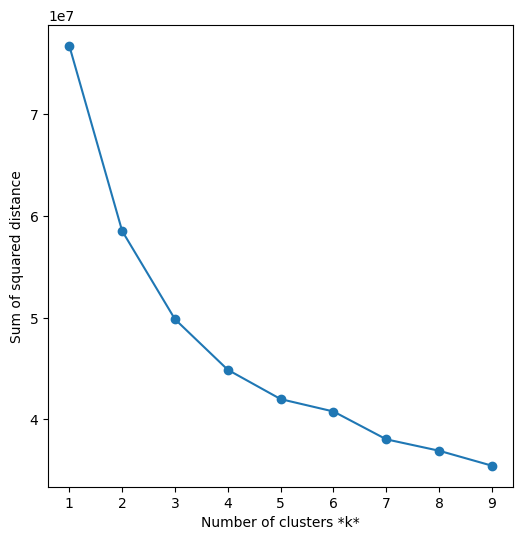

In [210]:
# Assuming X is your data
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.show()

In [188]:
clf = linear_model.LogisticRegression()

In [192]:
X = df[f_cols]
Y = df['readmitted']

In [193]:
clf.fit(X, Y)

LogisticRegression()

In [194]:
clf.score(X, Y)

0.9104371654527126

In [195]:
clf.intercept_

array([-0.00850206])

In [196]:
for feat, coef in zip(f_cols, clf.coef_[0]):
    print(" {:>20}: {}".format(feat, coef))

                 race: -0.016214965222419952
                  age: 0.007254098349542884
    admission_type_id: 0.004049873214564013
 discharge_disposition_id: 0.010282118754433845
  admission_source_id: -0.0025264257393297317
     time_in_hospital: 0.040267558999510324
    medical_specialty: 0.00562182488520778
   num_lab_procedures: 0.0006789202289012436
       num_procedures: -0.03494079719827803
      num_medications: 0.0037191229424847613
    number_outpatient: -0.004278252477944228
     number_emergency: 0.07738858609512275
     number_inpatient: 0.3349758055171924
               diag_1: -0.027376222226507083
               diag_2: -0.005373383492519511
               diag_3: 0.003628306796209368
     number_diagnoses: 0.03230256080660902
            metformin: -0.003800679463087557
          repaglinide: 0.01911582636505798
          nateglinide: -0.00045231573836756783
       chlorpropamide: 0.0411056654449678
            glipizide: 0.003156095692027207
            glyburide: 0

In [151]:
#'number_emergency', 
numeric_features = ['age','time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
                    'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses',
                    'health_index', 'severity_of_disease', 'number_of_changes', 
                    'metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide',\
            'glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol',\
            'troglitazone','tolazamide','insulin','glyburide-metformin','glipizide-metformin',\
            'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone', 'change', 'diabetesMed']

categorical_features = []
rejected_features = []

for col in df.columns :
    if col not in numeric_features :
        categorical_features.append(col)

In [152]:
for col in categorical_features : 
    data_crosstab = pd.crosstab(df['readmitted'],  
                                df[col], 
                                margins = False) 

    stat, p, dof, expected = scipy.stats.chi2_contingency(data_crosstab)
    if p < 0.4 :
	    print(p, col, 'is significant')
    else:
        print(p, col, 'is not significant')
        rejected_features.append(col)

#rejected_features.remove('admission_type_id')
print('\n\n', rejected_features)
df.drop(rejected_features, axis = 1, inplace = True)

0.011000300535663983 race is significant
0.5649365136977416 gender is not significant
0.018235268523518786 admission_type_id is significant
2.2858748125338644e-177 discharge_disposition_id is significant
0.08688102822592889 admission_source_id is significant
1.6017605412957235e-06 medical_specialty is significant
7.047139731365279e-16 diag_1 is significant
6.0033786077833e-08 diag_2 is significant
1.8929103548343518e-07 diag_3 is significant
0.0 readmitted is significant


 ['gender']


In [153]:
rejected_features = []
for col in numeric_features:
    rho , pval = scipy.stats.spearmanr(df['readmitted'], df[col])
    print(col, rho, pval)
    

print('\n\n')
for col in numeric_features :
    rho , pval = scipy.stats.spearmanr(df['readmitted'], df[col])
    if pval < 0.4 : 
        print(col, 'is significant')
    else : 
        print(col, 'is not significant')
        rejected_features.append(col)

print(rejected_features)
## lets remove rejected_features
df.drop(rejected_features, axis = 1, inplace=True)

age 0.04699517679216786 9.763088866595248e-36
time_in_hospital 0.05865854050984207 9.88788178411997e-55
num_lab_procedures 0.03205313657980457 1.7609829498436774e-17
num_procedures 0.0037141294409280727 0.32429372315318505
num_medications 0.042222285096625414 3.6376441367407055e-29
number_outpatient 0.01601746179619878 2.127747332310953e-05
number_emergency 0.030398363931386705 7.082148759492669e-16
number_inpatient 0.08473011804528006 2.282652550803581e-112
number_diagnoses 0.041698289703234574 1.7372423993096614e-28
health_index -0.059116808233520196 1.4569669084834509e-55
severity_of_disease 0.04806287810890338 2.6561107236329494e-37
number_of_changes 0.023429199496016746 5.016715550160748e-10
metformin -0.012307695913182955 0.0010892989066281955
repaglinide 0.013893369427945397 0.0002266892755126597
nateglinide -0.0036143033427687714 0.33746793782562867
chlorpropamide -0.005245021489876711 0.16393672122556519
glimepiride -0.0017617626444352118 0.6401111312951957
acetohexamide -0.00

In [110]:
df.head()

,race,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,glipizide,glyburide,tolazamide,insulin,change,diabetesMed,readmitted,health_index,severity_of_disease,number_of_changes
0,0,5,6,18,1,1,pediatrics,41,0,1,...,-20,-20,-20,-20,-1,-1,0,1.000000,0.000009,0
1,0,15,1,1,7,3,missing,59,0,18,...,-20,-20,-20,10,1,1,0,1.000000,0.000018,1
2,1,25,1,1,7,2,missing,11,5,13,...,0,-20,-20,-20,-1,1,0,0.333333,0.000007,0
3,0,35,1,1,7,2,missing,44,1,16,...,-20,-20,-20,10,1,1,0,1.000000,0.000014,1
4,0,45,1,1,7,1,missing,51,0,8,...,0,-20,-20,0,1,1,0,1.000000,0.000013,0


In [160]:
df.medical_specialty.unique()

array([4, 2, 0, 6, 7, 5, 3, 1])

In [161]:
df.diag_1.unique()

array([1, 7, 8, 6, 0, 9, 4, 5, 2, 3])

In [156]:
# Encode categorical features
from sklearn.preprocessing import LabelEncoder

In [159]:
cat_cols = ['medical_specialty', 'diag_1', 'diag_2', 'diag_3']

le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

In [162]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
race,70431.0,0.269853,0.535429,0.000000e+00,0.000000,0.000000,0.000000,2.000000
age,70431.0,65.516676,15.977185,5.000000e+00,55.000000,65.000000,75.000000,95.000000
admission_type_id,70431.0,1.844330,1.370545,1.000000e+00,1.000000,1.000000,3.000000,5.000000
discharge_disposition_id,70431.0,2.058128,3.656561,1.000000e+00,1.000000,1.000000,1.000000,18.000000
admission_source_id,70431.0,4.988130,2.926673,1.000000e+00,1.000000,7.000000,7.000000,11.000000
time_in_hospital,70431.0,4.283682,2.939699,1.000000e+00,2.000000,3.000000,6.000000,14.000000
medical_specialty,70431.0,1.547614,1.736881,0.000000e+00,0.000000,2.000000,2.000000,7.000000
num_lab_procedures,70431.0,42.917011,19.902483,1.000000e+00,31.000000,44.000000,57.000000,132.000000
num_procedures,70431.0,1.422058,1.754894,0.000000e+00,0.000000,1.000000,2.000000,6.000000
num_medications,70431.0,15.666723,8.282795,1.000000e+00,10.000000,14.000000,20.000000,81.000000


In [178]:
# Determine the optimal number of clusters (example using the Elbow method)
inertia = []
K = range(1, 11)  # Test K from 1 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

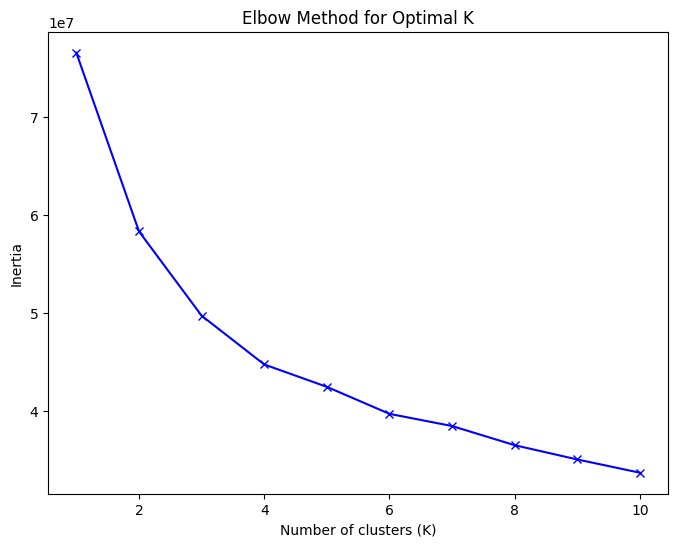

In [179]:

plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

In [180]:
# Based on the Elbow plot, let's assume the optimal K is 4
optimal_k = 6

# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X)
cluster_labels = kmeans.labels_



In [181]:
# Add cluster labels to the original dataset
df['cluster'] = cluster_labels

# Analyze the clusters
print(df.groupby('cluster').mean())



             race        age  admission_type_id  discharge_disposition_id  \
cluster                                                                     
0        0.392665  45.906318           1.658678                  1.899201   
1        0.183157  74.471398           2.348941                  2.100530   
2        0.245605  72.977222           1.724767                  1.710654   
3        0.233209  70.981174           1.731343                  1.965400   
4        0.353153  47.166759           2.184320                  1.920907   
5        0.223259  75.676617           1.727114                  2.560883   

         admission_source_id  time_in_hospital  medical_specialty  \
cluster                                                             
0                   5.278504          3.887364           1.571823   
1                   4.652119          3.326059           1.629873   
2                   4.671041          4.465049           1.526698   
3                   5.772642          

In [183]:
from pandas.plotting import parallel_coordinates

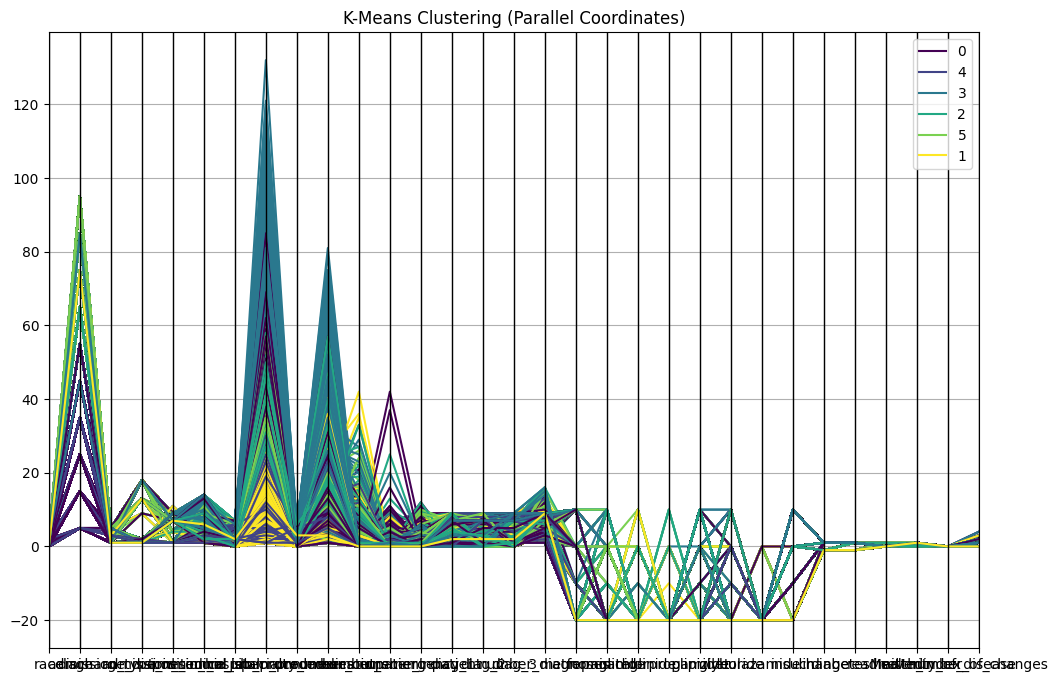

In [184]:
# Visualize the clusters (example using a parallel coordinates plot)
plt.figure(figsize=(12, 8))
parallel_coordinates(df, 'cluster', colormap='viridis')
plt.title('K-Means Clustering (Parallel Coordinates)')
plt.show()

In [190]:
# Select relevant features
f_cols = list(df.columns)
f_cols.remove('readmitted')
X = df[f_cols]

In [175]:
# Apply K-Means clustering (assuming 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
cluster_labels = kmeans.labels_

In [177]:
# Add cluster labels to the original dataset
df['cluster'] = cluster_labels

# Analyze the clusters
print(df.groupby('cluster').mean())

             race        age  admission_type_id  discharge_disposition_id  \
cluster                                                                     
0        0.388622  46.251257           1.699173                  1.881022   
1        0.239486  67.230991           2.192647                  2.050135   
2        0.222391  75.447492           1.686046                  2.165930   

         admission_source_id  time_in_hospital  medical_specialty  \
cluster                                                             
0                   5.192411          4.139768           1.579300   
1                   4.361619          3.259122           1.659967   
2                   5.305630          5.078851           1.451234   

         num_lab_procedures  num_procedures  num_medications  ...  glipizide  \
cluster                                                       ...              
0                 50.895328        1.412038        15.614172  ... -17.740025   
1                 19.839384 

In [155]:
df.dtypes

race                          int64
age                           int64
admission_type_id             int64
discharge_disposition_id      int64
admission_source_id           int64
time_in_hospital              int64
medical_specialty            object
num_lab_procedures            int64
num_procedures                int64
num_medications               int64
number_outpatient             int64
number_emergency              int64
number_inpatient              int64
diag_1                       object
diag_2                       object
diag_3                       object
number_diagnoses              int64
metformin                     int64
repaglinide                   int64
nateglinide                   int64
chlorpropamide                int64
glipizide                     int64
glyburide                     int64
tolazamide                    int64
insulin                       int64
change                        int64
diabetesMed                   int64
readmitted                  

In [115]:
categorical_features.remove('gender')

In [124]:
for col in numeric_features:
    if col in rejected_features:
        numeric_features.remove(col)
for col in ['acetohexamide', 'pioglitazone', 'acarbose', 'troglitazone', 'glipizide-metformin', 'metformin-rosiglitazone']:
    if col in numeric_features:
        numeric_features.remove(col)

In [120]:
# Preprocessing steps (example)
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [121]:
# Encode categorical variables
categorical_cols = categorical_features
ohe = OneHotEncoder(handle_unknown='ignore')
categorical_data = ohe.fit_transform(df[categorical_cols])
categorical_data = pd.DataFrame(categorical_data.toarray(), columns=ohe.get_feature_names_out(categorical_cols))

In [127]:
categorical_data.shape

(70431, 61)

In [125]:
# Scale numerical features
numerical_cols = numeric_features
scaler = StandardScaler()
numerical_data = scaler.fit_transform(df[numerical_cols])

In [129]:
# Combine preprocessed data
X = pd.concat([categorical_data, pd.DataFrame(numerical_data, columns=numerical_cols)], axis=1)

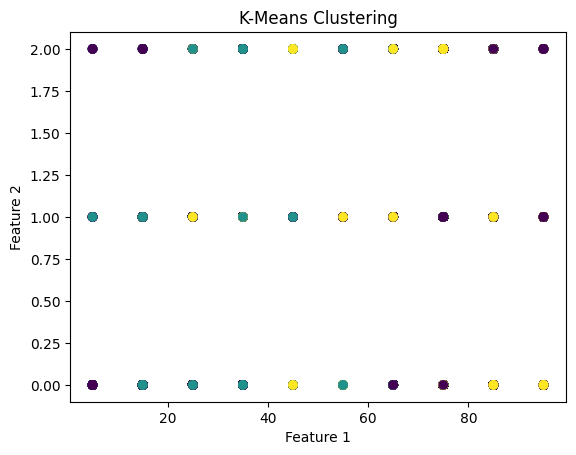

In [134]:
# Assuming 'feature1' and 'feature2' are the two numerical features
plt.scatter(df['age'], df['race'], c=cluster_labels)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-Means Clustering')
plt.show()

In [130]:
# Initialize the K-Means model
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model to the data
kmeans.fit(X)

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

In [131]:
cluster_labels

array([0, 1, 0, ..., 2, 2, 0], dtype=int32)

In [106]:
from sklearn.cluster import KMeans

In [109]:
kmeans = KMeans(n_clusters=3,init='random',max_iter=100,random_state=10,n_init='auto')
kmeans.fit()
plt.scatter(features[kmeans.labels_==0,0],features[kmeans.labels_==0,1])
plt.scatter(features[kmeans.labels_==1,0],features[kmeans.labels_==1,1])
plt.scatter(features[kmeans.labels_==2,0],features[kmeans.labels_==2,1])
plt.show()

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

In [105]:
df.shape

(70431, 31)

In [111]:
df.head()

,race,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_medications,number_outpatient,...,glipizide,glyburide,tolazamide,insulin,change,diabetesMed,readmitted,health_index,severity_of_disease,number_of_changes
0,0,5,5,25,1,1,pediatrics,41,1,0,...,-20,-20,-20,-20,-1,-1,0,1.000000,0.000009,0
1,0,15,1,1,7,3,missing,59,18,0,...,-20,-20,-20,10,1,1,0,1.000000,0.000017,1
2,1,25,1,1,7,2,missing,11,13,2,...,0,-20,-20,-20,-1,1,0,0.333333,0.000007,0
3,0,35,1,1,7,2,missing,44,16,0,...,-20,-20,-20,10,1,1,0,1.000000,0.000014,1
4,0,45,1,1,7,1,missing,51,8,0,...,0,-20,-20,0,1,1,0,1.000000,0.000013,0


<Axes: ylabel='count'>

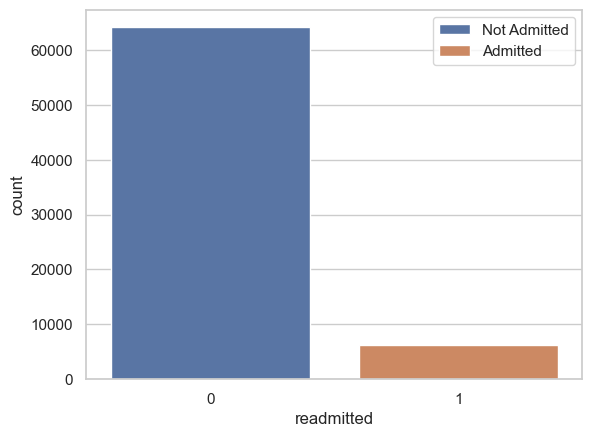

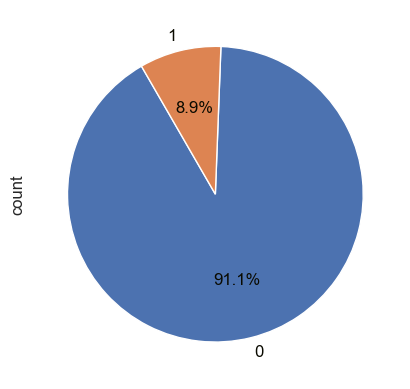

In [61]:
##  
plt.figure()
sns.set_theme(style="whitegrid")
ax = sns.countplot(x = 'readmitted', data = df, hue = 'readmitted')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels = ['Not Admitted', 'Admitted'])
plt.figure()
df.readmitted.value_counts().plot.pie(autopct="%1.1f%%", startangle=120,
                                        textprops={'fontsize': 12, 'color':'#0a0a00'})

In [58]:
df.diag_1.unique()

array(['diabetes', 'other', 'pregnecy', 'neoplasms', 'circulatory',
       'respiratory', 'injury', 'musculoskeletal', 'digestive',
       'genitourinary'], dtype=object)

In [56]:
# get the count of non-numeric columns
non_numeric_cols_count = len(df.select_dtypes(exclude=['number']).columns)
print("Count of non-numeric columns:", non_numeric_cols_count)

Count of non-numeric columns: 4


In [36]:
df.shape

(70431, 42)

In [57]:
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,0,0,5,5,18,1,1,pediatrics,41,0,...,-20,-20,-20,-20,-20,-20,-20,-1,-1,0
1,0,0,15,1,1,7,3,missing,59,0,...,-20,10,-20,-20,-20,-20,-20,1,1,0
2,1,0,25,1,1,7,2,missing,11,5,...,-20,-20,-20,-20,-20,-20,-20,-1,1,0
3,0,1,35,1,1,7,2,missing,44,1,...,-20,10,-20,-20,-20,-20,-20,1,1,0
4,0,1,45,1,1,7,1,missing,51,0,...,-20,0,-20,-20,-20,-20,-20,1,1,0


In [ ]:
a